<a href="https://colab.research.google.com/github/ThamirisAdriano/iadt-deteccao-anomalias/blob/master/Detector_de_defeitos_em_imagens_com_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import shutil
import os

# Remover a pasta `perfect_pieces` e recriar
shutil.rmtree('perfect_pieces', ignore_errors=True)
os.makedirs('perfect_pieces/perfect', exist_ok=True)
os.makedirs('perfect_pieces/defective', exist_ok=True)

# Listar os arquivos na raiz para garantir que não há duplicatas fora das pastas
print("Arquivos restantes no diretório principal:")
print(os.listdir())


Arquivos restantes no diretório principal:
['.config', 'perfect_pieces', '.ipynb_checkpoints', 'sample_data']


In [41]:
from google.colab import files
import os
from shutil import move

# Fazer upload das imagens
uploaded = files.upload()  # Faça o upload de suas imagens.

# Criar pastas para organizar os dados
os.makedirs('perfect_pieces/perfect', exist_ok=True)
os.makedirs('perfect_pieces/defective', exist_ok=True)

# Lista de arquivos esperados para peças perfeitas e defeituosas
perfect_files = ['perfect1.jpeg', 'perfect2.jpeg', 'perfect3.jpeg', 'perfect4.jpeg', 'perfect5.jpeg', 'perfect6.jpeg', 'perfect7.jpeg', 'perfect8.jpeg']
defective_files = ['missing1.jpeg', 'missing2.jpeg', 'missing3.jpeg', 'missing4.jpeg', 'missing5.jpeg', 'missing6.jpeg', 'missing7.jpeg', 'missing8.jpeg']

# Mover os arquivos para as pastas corretas
for file_name in uploaded.keys():
    if file_name in perfect_files:
        move(file_name, f'perfect_pieces/perfect/{file_name}')
    elif file_name in defective_files:
        move(file_name, f'perfect_pieces/defective/{file_name}')
    else:
        print(f"Aviso: {file_name} não está na lista de arquivos esperados.")



Saving missing1.jpeg to missing1.jpeg
Saving missing2.jpeg to missing2.jpeg
Saving missing3.jpeg to missing3.jpeg
Saving missing4.jpeg to missing4.jpeg
Saving missing5.jpeg to missing5.jpeg
Saving missing6.jpeg to missing6.jpeg
Saving missing7.jpeg to missing7.jpeg
Saving missing8.jpeg to missing8.jpeg
Saving perfect1.jpeg to perfect1.jpeg
Saving perfect2.jpeg to perfect2.jpeg
Saving perfect3.jpeg to perfect3.jpeg
Saving perfect4.jpeg to perfect4.jpeg
Saving perfect5.jpeg to perfect5.jpeg
Saving perfect6.jpeg to perfect6.jpeg
Saving perfect7.jpeg to perfect7.jpeg
Saving perfect8.jpeg to perfect8.jpeg


Classes detectadas: {'defective': 0, 'perfect': 1}


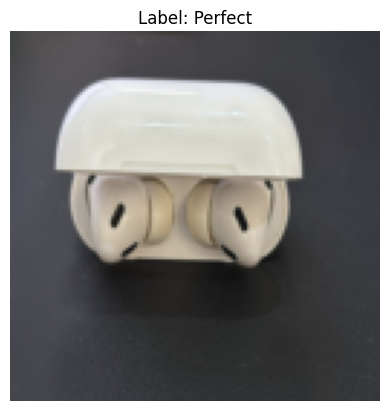

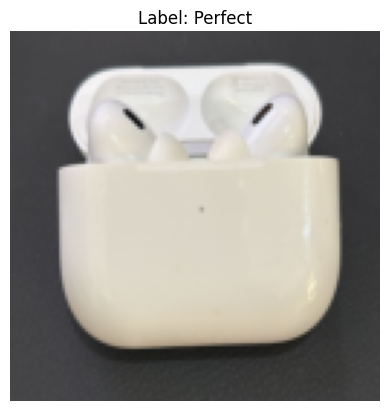

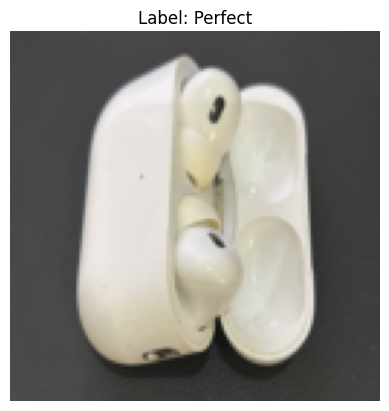

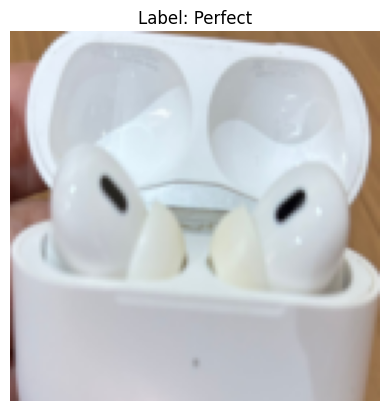

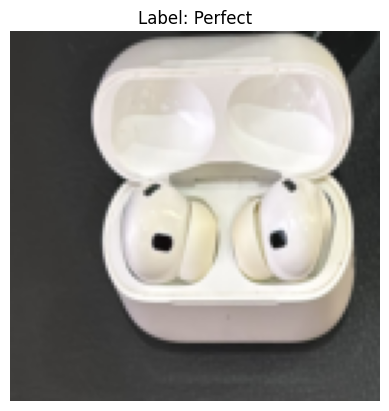

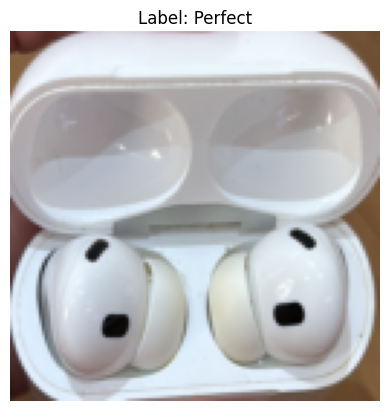

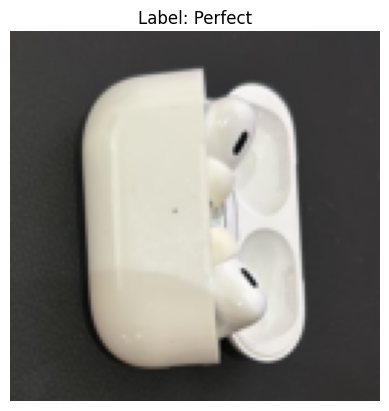

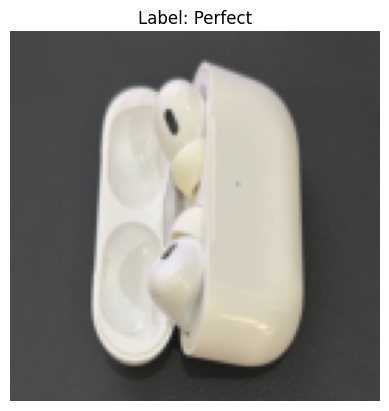

Iniciando o treinamento...
Epoch [1/20], Loss: 0.0857
Epoch [2/20], Loss: 0.0841
Epoch [3/20], Loss: 0.0783
Epoch [4/20], Loss: 0.0684
Epoch [5/20], Loss: 0.0594
Epoch [6/20], Loss: 0.0496
Epoch [7/20], Loss: 0.0406
Epoch [8/20], Loss: 0.0329
Epoch [9/20], Loss: 0.0264
Epoch [10/20], Loss: 0.0219
Epoch [11/20], Loss: 0.0187
Epoch [12/20], Loss: 0.0159
Epoch [13/20], Loss: 0.0136
Epoch [14/20], Loss: 0.0118
Epoch [15/20], Loss: 0.0101
Epoch [16/20], Loss: 0.0086
Epoch [17/20], Loss: 0.0079
Epoch [18/20], Loss: 0.0072
Epoch [19/20], Loss: 0.0064
Epoch [20/20], Loss: 0.0059
Avaliando as imagens...


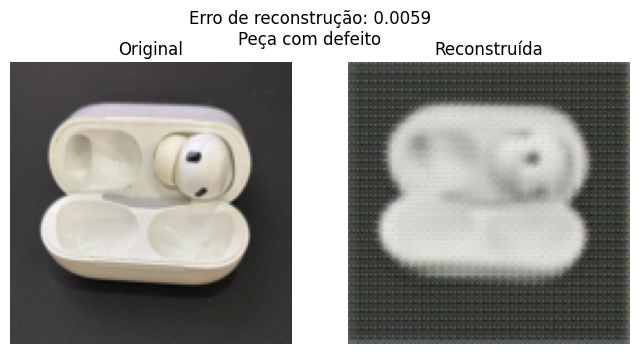

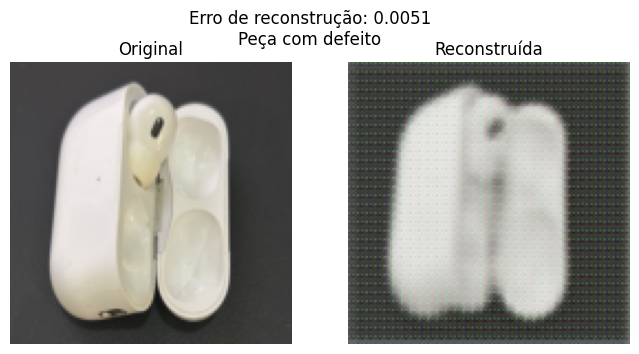

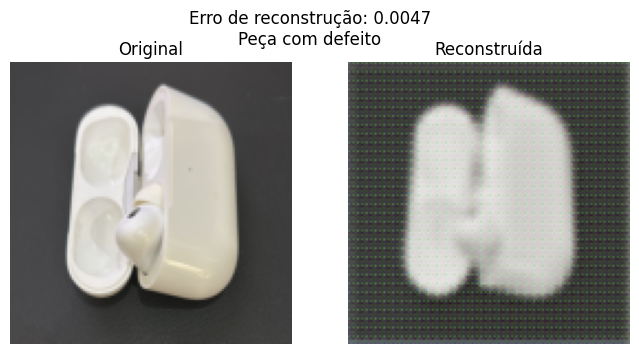

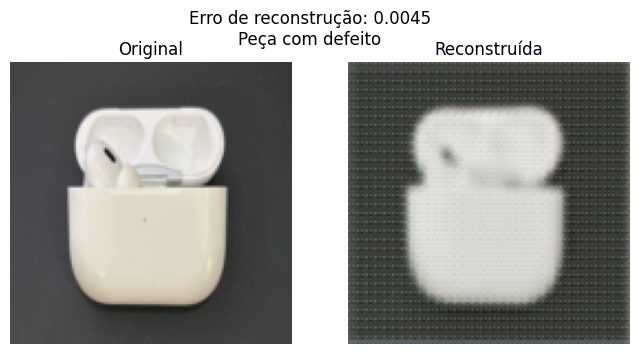

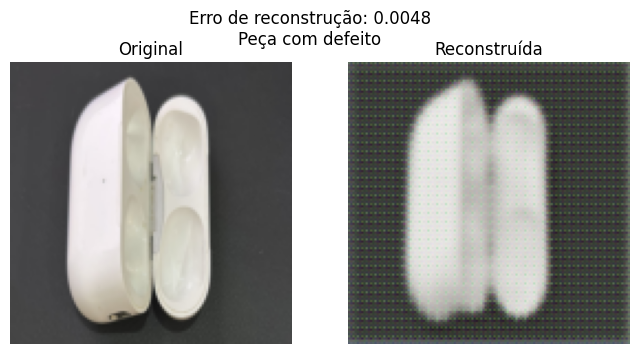

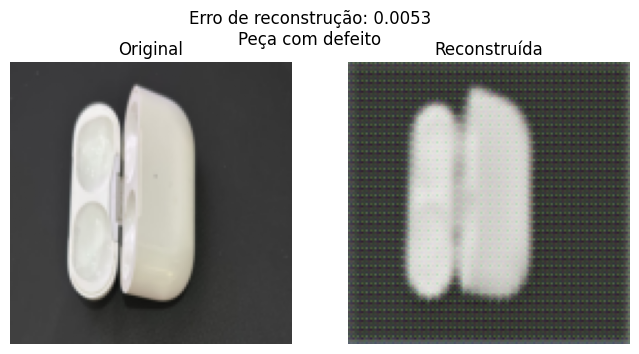

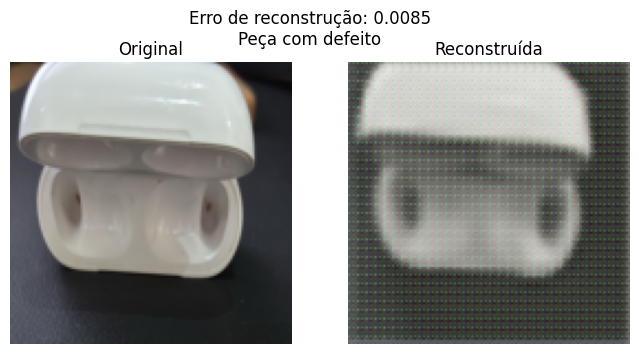

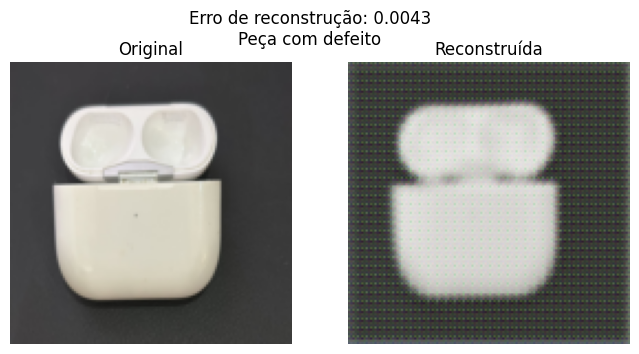

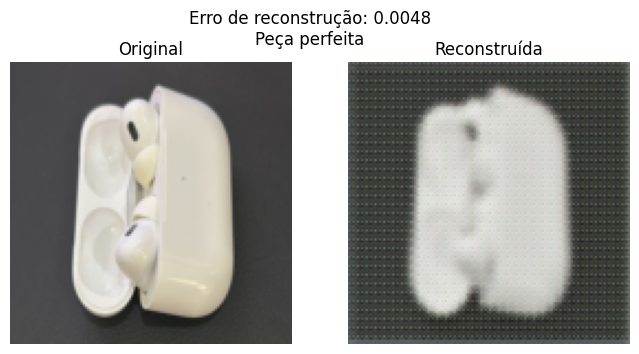

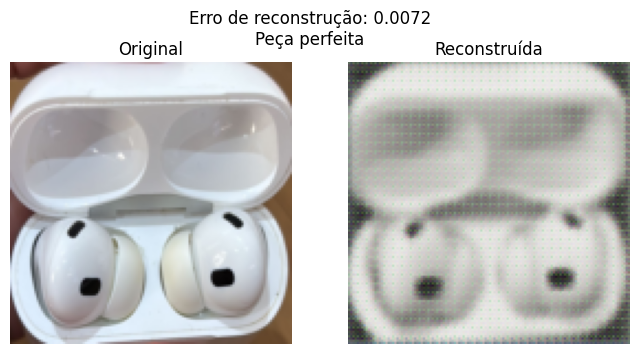

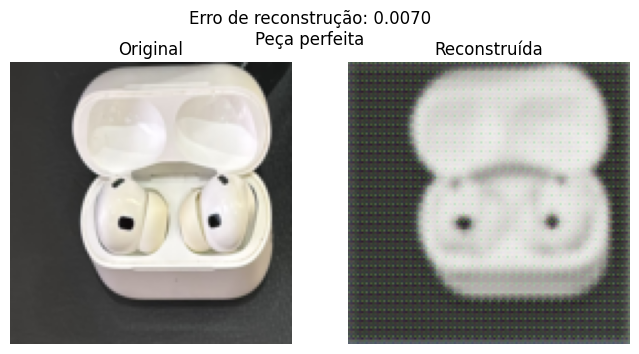

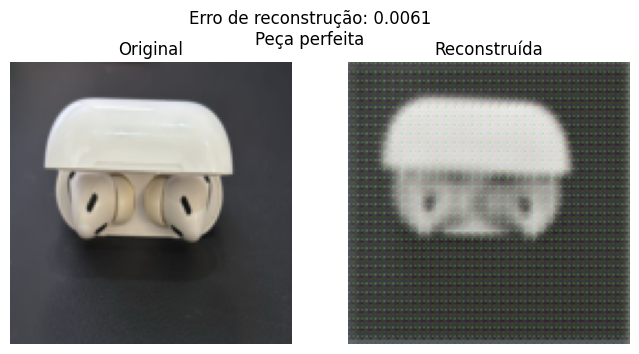

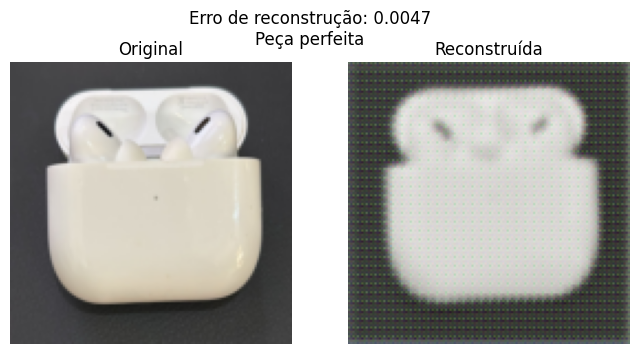

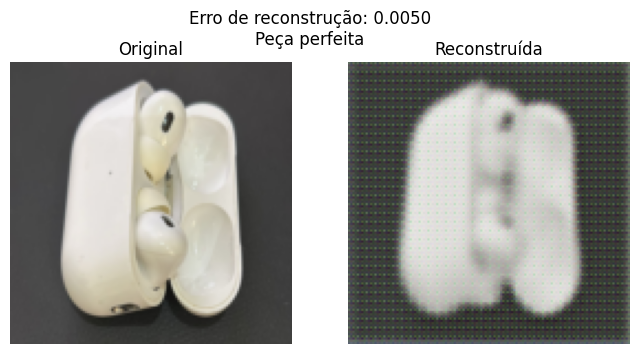

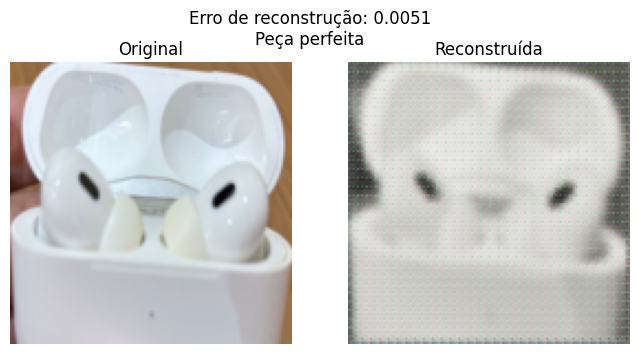

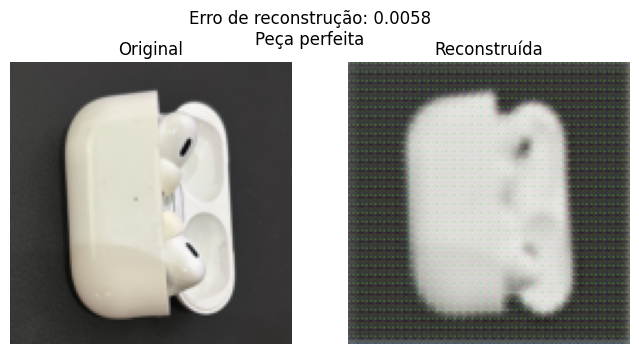

Limiar para detecção de defeitos: 0.0075
Erro: 0.0059, Classificação: Perfeito
Erro: 0.0051, Classificação: Perfeito
Erro: 0.0047, Classificação: Perfeito
Erro: 0.0045, Classificação: Perfeito
Erro: 0.0048, Classificação: Perfeito
Erro: 0.0053, Classificação: Perfeito
Erro: 0.0085, Classificação: Defeituoso
Erro: 0.0043, Classificação: Perfeito
Erro: 0.0048, Classificação: Perfeito
Erro: 0.0072, Classificação: Perfeito
Erro: 0.0070, Classificação: Perfeito
Erro: 0.0061, Classificação: Perfeito
Erro: 0.0047, Classificação: Perfeito
Erro: 0.0050, Classificação: Perfeito
Erro: 0.0051, Classificação: Perfeito
Erro: 0.0058, Classificação: Perfeito


In [52]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# Configurações básicas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 128
batch_size = 1

# Transformações nas imagens
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# Carregando o dataset
dataset = ImageFolder(root='perfect_pieces', transform=transform)
print("Classes detectadas:", dataset.class_to_idx)  # Verificando as classes e seus índices
perfect_idx = dataset.class_to_idx['perfect']

# Separando os dados perfeitos para treino
train_indices = [i for i, (_, label) in enumerate(dataset) if label == perfect_idx]
train_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices)
)

# Visualizando imagens do dataset
for img, label in train_loader:
    plt.imshow(img[0].permute(1, 2, 0))
    plt.title(f"Label: {'Perfect' if label == perfect_idx else 'Defective'}")
    plt.axis('off')
    plt.show()

# Definindo o modelo Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Inicializando o modelo
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Treinamento
epochs = 20
print("Iniciando o treinamento...")
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for img, _ in train_loader:
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# Testando as imagens
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
model.eval()
errors = []

# Avaliação
print("Avaliando as imagens...")
for img, label in test_loader:
    img = img.to(device)
    output = model(img).detach()
    error = torch.mean((img - output) ** 2).item()
    errors.append((error, label.item()))

    # Visualizando original e reconstruída
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].permute(1, 2, 0).cpu())
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output[0].permute(1, 2, 0).cpu())
    plt.title("Reconstruída")
    plt.axis('off')

    plt.suptitle(f"Erro de reconstrução: {error:.4f}\n{'Peça perfeita' if label == perfect_idx else 'Peça com defeito'}")
    plt.show()

# Definindo um limiar dinâmico para detecção de defeitos
perfect_errors = [e for e, l in errors if l == perfect_idx]
threshold = np.mean(perfect_errors) + 2 * np.std(perfect_errors)
print(f"Limiar para detecção de defeitos: {threshold:.4f}")

# Classificando
for error, label in errors:
    print(f"Erro: {error:.4f}, Classificação: {'Perfeito' if error <= threshold else 'Defeituoso'}")
